<a href="https://colab.research.google.com/github/bharti001/Machine-Learning-/blob/main/MedMnist_final_project_Bharti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparative Modeling of Pneumonia and Pathology Images**:


## Pneumonia & Pathology Image Classification — MedMNIST
This code implements the full workflow for two datasets: **PneumoniaMNIST** and **PathMNIST**, comparing classical ML methods to CNN and transfer learning (ResNet18)

In [1]:
!pip install -q medmnist torch torchvision torchaudio scikit-learn matplotlib
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.9 MB/s eta 0:00:00


##Imports & Config

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# Define the path to the directory you want to create on Google Drive
drive_data_root = '/content/drive/MyDrive/data' # You can change 'MyDrive/data' to your desired path

# Create the directory if it doesn't exist
os.makedirs(drive_data_root, exist_ok=True)

print(f"Directory '{drive_data_root}' created successfully (or already exists).")

Directory '/content/drive/MyDrive/data' created successfully (or already exists).


In [4]:
import os, math, random, numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

import medmnist
from medmnist import INFO, Evaluator
from medmnist import PneumoniaMNIST, PathMNIST

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
print('Device:', device)

Device: cuda


## Dataset Loading (PneumoniaMNIST & PathMNIST)
28×28 images by default. Evaluated on both datasets.

In [7]:
# Configure datasets
DATASETS = {
    'pneumonia': {
        'cls': PneumoniaMNIST,
        'task': 'binary',
        'n_classes': 2,
        'info_key': 'pneumoniamnist',
        'n_channels': 1 # Add number of channels
    },
    'path': {
        'cls': PathMNIST,
        'task': 'multiclass',
        'n_classes': 9,
        'info_key': 'pathmnist',
        'n_channels': 3 # Add number of channels
    }
}

data_root = '/content/drive/MyDrive/data' # Use the Google Drive path
os.makedirs(data_root, exist_ok=True) # Create the directory if it doesn't exist
print(f"Data root directory: {data_root}")

def get_dataloaders(dataset_key='pneumonia', batch_size=128, download=True):
    entry = DATASETS[dataset_key]
    ds_cls = entry['cls']
    info = INFO[entry['info_key']]
    n_channels = entry['n_channels'] # Get number of channels

    # Train/Val/Test splits provided by MedMNIST
    # Adjust normalization based on number of channels
    if n_channels == 1:
        train_tf = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[.5], std=[.5])
        ])
        test_tf = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[.5], std=[.5])
        ])
    elif n_channels == 3:
        train_tf = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]) # Normalize for 3 channels
        ])
        test_tf = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]) # Normalize for 3 channels
        ])
    else:
        raise ValueError(f"Unsupported number of channels: {n_channels}")


    print(f"Attempting to load {dataset_key} dataset from: {data_root}")
    train_ds = ds_cls(split='train', root=data_root, transform=train_tf, download=download)
    val_ds   = ds_cls(split='val',   root=data_root, transform=test_tf,  download=download)
    test_ds  = ds_cls(split='test',  root=data_root, transform=test_tf,  download=download)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)

    return train_ds, val_ds, test_ds, train_loader, val_loader, test_loader

# Quick check
for key in DATASETS.keys():
    _, _, _, _, _, _ = get_dataloaders(key, download=True)
print("Datasets downloaded and ready.")

Data root directory: /content/drive/MyDrive/data
Attempting to load pneumonia dataset from: /content/drive/MyDrive/data
Attempting to load path dataset from: /content/drive/MyDrive/data
Datasets downloaded and ready.


##Visualization
Class distribution and sample images

/tmp/ipython-input-3038223342.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[i].set_title(str(int(label)))


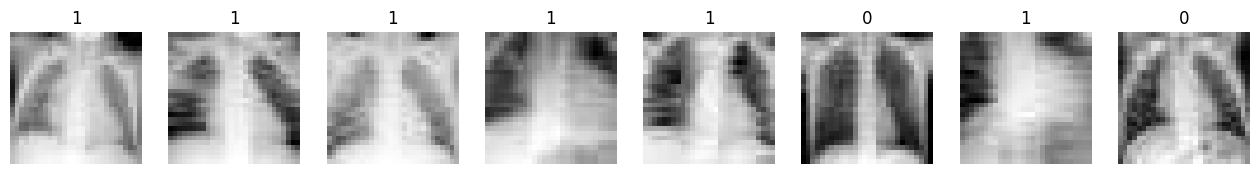

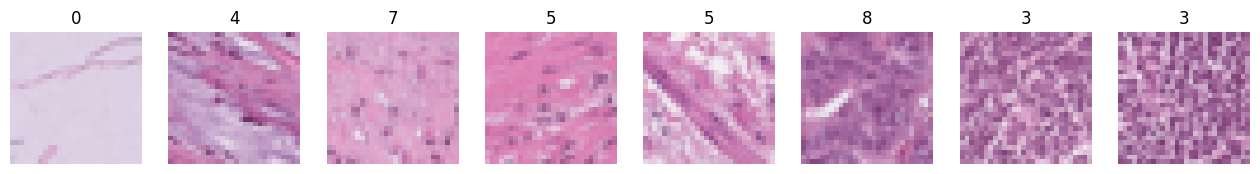

In [8]:
def show_samples(dataset_key='pneumonia', n=8):
    ds_cls = DATASETS[dataset_key]['cls']
    ds = ds_cls(split='train', root=data_root, download=True)
    fig, ax = plt.subplots(1, n, figsize=(n*2, 2))
    for i in range(n):
        img, label = ds[i]
        if hasattr(img, 'numpy'):
            arr = img.numpy()
        else:
            arr = np.array(img)
        if arr.ndim == 3:
            arr = arr.squeeze()
        ax[i].imshow(arr, cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(str(int(label)))
    plt.show()

show_samples('pneumonia', n=8)
show_samples('path', n=8)

## 4. Classical ML (LR, SVM, kNN, RF)
Flattened pixels → Standardize → PCA → Classifier

In [9]:
def prepare_xy_for_classical(ds):
    X = []
    y = []
    for i in range(len(ds)):
        img, label = ds[i]
        arr = np.array(img)
        if arr.ndim == 3:
            arr = arr.squeeze()
        X.append(arr.flatten())
        y.append(int(label.squeeze())) # Access the scalar value before converting to int
    return np.array(X), np.array(y)

def classical_pipeline(model):
    return Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('pca', PCA(n_components=64, random_state=SEED)),
        ('clf', model)
    ])

def eval_classical(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    f1  = f1_score(y_val, preds, average='weighted')
    precision = precision_score(y_val, preds, average='weighted', zero_division=0) # Add Precision
    recall = recall_score(y_val, preds, average='weighted', zero_division=0)     # Add Recall
    return acc, f1, precision, recall, preds # Return new metrics

def run_classical_for_dataset(dataset_key='pneumonia'):
    train_ds = DATASETS[dataset_key]['cls'](split='train', root=data_root, download=True)
    val_ds   = DATASETS[dataset_key]['cls'](split='val', root=data_root, download=True)

    X_train, y_train = prepare_xy_for_classical(train_ds)
    X_val,   y_val   = prepare_xy_for_classical(val_ds)

    results = {}

    models = {
        'LogReg': LogisticRegression(max_iter=1000, n_jobs=None), # Increased max_iter
        'SVM-RBF': SVC(kernel='rbf', probability=True),
        'kNN': KNeighborsClassifier(n_neighbors=5),
        'RandomForest': RandomForestClassifier(n_estimators=200, random_state=SEED)
    }

    for name, clf in models.items():
        acc, f1, precision, recall, preds = eval_classical(classical_pipeline(clf), X_train, y_train, X_val, y_val) # Get new metrics
        results[name] = {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall} # Store new metrics
        print(dataset_key, name, 'ACC:', round(acc,4), 'F1:', round(f1,4), 'Precision:', round(precision,4), 'Recall:', round(recall,4)) # Print new metrics

    return results

classical_results = {}
for key in DATASETS.keys():
    classical_results[key] = run_classical_for_dataset(key)

print(classical_results)

pneumonia LogReg ACC: 0.9523 F1: 0.9521 Precision: 0.952 Recall: 0.9523
pneumonia SVM-RBF ACC: 0.9695 F1: 0.9692 Precision: 0.9693 Recall: 0.9695
pneumonia kNN ACC: 0.958 F1: 0.9577 Precision: 0.9577 Recall: 0.958
pneumonia RandomForest ACC: 0.937 F1: 0.9359 Precision: 0.9364 Recall: 0.937
path LogReg ACC: 0.5353 F1: 0.507 Precision: 0.5219 Recall: 0.5353
path SVM-RBF ACC: 0.69 F1: 0.685 Precision: 0.6922 Recall: 0.69
path kNN ACC: 0.4813 F1: 0.451 Precision: 0.5038 Recall: 0.4813
path RandomForest ACC: 0.6953 F1: 0.6875 Precision: 0.7004 Recall: 0.6953
{'pneumonia': {'LogReg': {'accuracy': 0.9522900763358778, 'f1': 0.9521136754326612, 'precision': 0.9520174482006544, 'recall': 0.9522900763358778}, 'SVM-RBF': {'accuracy': 0.9694656488549618, 'f1': 0.9692355082213315, 'precision': 0.9693407070001145, 'recall': 0.9694656488549618}, 'kNN': {'accuracy': 0.9580152671755725, 'f1': 0.9576988238043309, 'precision': 0.9577110022988402, 'recall': 0.9580152671755725}, 'RandomForest': {'accuracy':

## Hyperparameter Tuning (Classical Models)

In [2]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt

def tune_svm(X_train, y_train, X_val, y_val):
    pipe = Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('pca', PCA(n_components=64, random_state=SEED)),
        ('clf', SVC(probability=True))
    ])
    params = {
        'clf__C': [0.1, 1, 10],
        'clf__gamma': ['scale', 0.01, 0.001],
        'clf__kernel': ['rbf']
    }
    grid = GridSearchCV(pipe, params, cv=3, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X_train, y_train)
    print("Best params:", grid.best_params_)
    preds = grid.predict(X_val)

    # Calculate all four metrics
    acc = accuracy_score(y_val, preds)
    f1  = f1_score(y_val, preds, average='weighted')
    precision = precision_score(y_val, preds, average='weighted', zero_division=0)
    recall = recall_score(y_val, preds, average='weighted', zero_division=0)

    # Return all four metrics
    return acc, f1, precision, recall

# PneumoniaMNIST
train_ds_pneumonia = DATASETS['pneumonia']['cls'](split='train', root=data_root, download=False)
val_ds_pneumonia   = DATASETS['pneumonia']['cls'](split='val',   root=data_root, download=False)
X_train_pneumonia, y_train_pneumonia = prepare_xy_for_classical(train_ds_pneumonia)
X_val_pneumonia,   y_val_pneumonia   = prepare_xy_for_classical(val_ds_pneumonia)

# PathMNIST
train_ds_path = DATASETS['path']['cls'](split='train', root=data_root, download=False)
val_ds_path   = DATASETS['path']['cls'](split='val',   root=data_root, download=False)
X_train_path, y_train_path = prepare_xy_for_classical(train_ds_path)
X_val_path,   y_val_path   = prepare_xy_for_classical(val_ds_path)

# Run hyperparameter tuning for SVM on PneumoniaMNIST and print results
print("--- PneumoniaMNIST SVM Tuning ---")
acc_pneumonia, f1_pneumonia, precision_pneumonia, recall_pneumonia = tune_svm(X_train_pneumonia, y_train_pneumonia, X_val_pneumonia, y_val_pneumonia)
print(f"Tuned SVM (PneumoniaMNIST) - Accuracy: {acc_pneumonia:.4f}, F1 Score: {f1_pneumonia:.4f}, Precision: {precision_pneumonia:.4f}, Recall: {recall_pneumonia:.4f}")

print("\n--- PathMNIST SVM Tuning ---")
# Run hyperparameter tuning for SVM on PathMNIST and print results
acc_path, f1_path, precision_path, recall_path = tune_svm(X_train_path, y_train_path, X_val_path, y_val_path)
print(f"Tuned SVM (PathMNIST) - Accuracy: {acc_path:.4f}, F1 Score: {f1_path:.4f}, Precision: {precision_path:.4f}, Recall: {recall_path:.4f}")


In [11]:
import pandas as pd

# Reshape the dictionary for better table format
data = []
for dataset, models in classical_results.items():
    for model, metrics in models.items():
        data.append({
            'Dataset': dataset,
            'Model': model,
            'Accuracy': metrics['accuracy'],
            'F1 Score': metrics['f1'],
            'Precision': metrics['precision'], # Added Precision
            'Recall': metrics['recall']       # Added Recall
        })

df = pd.DataFrame(data)
display(df)

,Dataset,Model,Accuracy,F1 Score,Precision,Recall
0,pneumonia,LogReg,0.952290,0.952114,0.952017,0.952290
1,pneumonia,SVM-RBF,0.969466,0.969236,0.969341,0.969466
2,pneumonia,kNN,0.958015,0.957699,0.957711,0.958015
3,pneumonia,RandomForest,0.937023,0.935948,0.936409,0.937023
4,path,LogReg,0.535286,0.507005,0.521915,0.535286
5,path,SVM-RBF,0.690024,0.684994,0.692156,0.690024
6,path,kNN,0.481307,0.451030,0.503789,0.481307
7,path,RandomForest,0.695322,0.687533,0.700378,0.695322


## CNN (from scratch)

In [19]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, n_classes): # Add in_channels parameter
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1), # Use in_channels here
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3):
    model = model.to(device)
    crit = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)

    best_val = 0.0
    for ep in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.squeeze().long().to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()

        # validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.squeeze().long().to(device)
                logits = model(xb)
                preds = logits.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        val_acc = correct / total
        print(f"Epoch {ep+1}: val_acc={val_acc:.4f}")
        if val_acc > best_val:
            best_val = val_acc
    return model

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.squeeze().long().to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            y_true.extend(yb.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0) # Calculate precision
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)       # Calculate recall
    print("Test ACC:", round(acc,4), "F1:", round(f1,4), "Precision:", round(precision,4), "Recall:", round(recall,4)) # Print new metrics
    print(classification_report(y_true, y_pred))
    return acc, f1, precision, recall, (y_true, y_pred) # Return new metrics

### Train/Evaluate CNN on both datasets

In [33]:
def run_cnn_for(dataset_key='pneumonia', epochs=5, batch_size=128):
    train_ds, val_ds, test_ds, train_loader, val_loader, test_loader = get_dataloaders(dataset_key, batch_size=batch_size)
    n_classes = DATASETS[dataset_key]['n_classes']
    n_channels = DATASETS[dataset_key]['n_channels'] # Get number of channels
    model = SimpleCNN(in_channels=n_channels, n_classes=n_classes) # Pass n_channels to SimpleCNN
    model = train_model(model, train_loader, val_loader, epochs=epochs, lr=1e-3)
    test_acc, test_f1, test_precision, test_recall, (y_true, y_pred) = evaluate_model(model, test_loader) # Correctly unpack all 5 values
    return {'accuracy': test_acc, 'f1': test_f1, 'precision': test_precision, 'recall': test_recall}, (y_true, y_pred) # Return metrics and labels

# Example (uncomment to run on Colab):
cnn_results = {}
cnn_labels = {} # Dictionary to store labels
for key in DATASETS.keys():
     metrics, (y_true, y_pred) = run_cnn_for(key, epochs=5)
     cnn_results[key] = metrics
     cnn_labels[key] = (y_true, y_pred)

print("CNN Results:", cnn_results)
# print("CNN Labels:", cnn_labels) # Uncomment to see labels

Attempting to load pneumonia dataset from: /content/drive/MyDrive/data
Epoch 1: val_acc=0.8874
Epoch 2: val_acc=0.9466
Epoch 3: val_acc=0.9351
Epoch 4: val_acc=0.9485
Epoch 5: val_acc=0.9504
Test ACC: 0.867 F1: 0.8629 Precision: 0.8723 Recall: 0.867
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       234
           1       0.85      0.96      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.84      0.85       624
weighted avg       0.87      0.87      0.86       624

Attempting to load path dataset from: /content/drive/MyDrive/data
Epoch 1: val_acc=0.7395
Epoch 2: val_acc=0.7823
Epoch 3: val_acc=0.8054
Epoch 4: val_acc=0.7817
Epoch 5: val_acc=0.8535
Test ACC: 0.8125 F1: 0.8175 Precision: 0.8436 Recall: 0.8125
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1338
           1       0.88      1.00      0.94       847
           2 

## Transfer Learning (ResNet18)
Upscale to 224×224 and use 3 channels

In [34]:
import torchvision.transforms as T
import torch

# Remove the custom ImageTransform class as it's not compatible with how medmnist applies transforms
# class ImageTransform:
#     def __init__(self, transform):
#         self.transform = transform

#     def __call__(self, sample):
#         img, label = sample
#         img = self.transform(img)
#         return img, label

def get_resnet_loaders(dataset_key='pneumonia', batch_size=64):
    # Use 3-channel 224x224 for ResNet
    # Apply transformations directly using T.Compose
    image_transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Lambda(lambda x: x.repeat(3,1,1) if x.shape[0] == 1 else x),  # Repeat only if 1 channel
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    ds_cls = DATASETS[dataset_key]['cls']
    # Pass the composed transformation directly to the dataset
    train_ds = ds_cls(split='train', root=data_root, transform=image_transform, download=True)
    val_ds   = ds_cls(split='val',   root=data_root, transform=image_transform,  download=True)
    test_ds  = ds_cls(split='test',  root=data_root, transform=image_transform,  download=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

def run_resnet18_for(dataset_key='pneumonia', epochs=3, lr=1e-3):
    train_loader, val_loader, test_loader = get_resnet_loaders(dataset_key)
    n_classes = DATASETS[dataset_key]['n_classes']

    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, n_classes)
    model = model.to(device)

    crit = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)

    best_val = 0.0
    for ep in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.squeeze().long().to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()

        # val
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.squeeze().long().to(device)
                preds = model(xb).argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        val_acc = correct/total
        print(f"[ResNet18 {dataset_key}] Epoch {ep+1} val_acc={val_acc:.4f}")
        best_val = max(best_val, val_acc)

    # test
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.squeeze().long().to(device)
            preds = model(xb).argmax(1)
            y_true.extend(yb.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0) # Calculate precision
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)       # Calculate recall
    print(f"[ResNet18 {dataset_key}] Test ACC={acc:.4f} F1={f1:.4f} Precision={precision:.4f} Recall={recall:.4f}") # Print all 4 metrics
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}, (y_true, y_pred) # Return all 4 metrics and labels

# Run ResNet18 for both datasets and store results
resnet_results = {}
resnet_labels = {} # Dictionary to store labels
for key in DATASETS.keys():
    metrics, (y_true, y_pred) = run_resnet18_for(key, epochs=3)
    resnet_results[key] = metrics
    resnet_labels[key] = (y_true, y_pred)


print("ResNet18 Results:", resnet_results)
# print("ResNet18 Labels:", resnet_labels) # Uncomment to see labels

[ResNet18 pneumonia] Epoch 1 val_acc=0.9714
[ResNet18 pneumonia] Epoch 2 val_acc=0.9294
[ResNet18 pneumonia] Epoch 3 val_acc=0.9485
[ResNet18 pneumonia] Test ACC=0.7484 F1=0.7060 Precision=0.8206 Recall=0.7484
[ResNet18 path] Epoch 1 val_acc=0.9418
[ResNet18 path] Epoch 2 val_acc=0.9627
[ResNet18 path] Epoch 3 val_acc=0.9692
[ResNet18 path] Test ACC=0.8563 F1=0.8593 Precision=0.8905 Recall=0.8563
ResNet18 Results: {'pneumonia': {'accuracy': 0.7483974358974359, 'f1': 0.7059687996513467, 'precision': 0.8206124314442413, 'recall': 0.7483974358974359}, 'path': {'accuracy': 0.8562674094707521, 'f1': 0.8592507527047164, 'precision': 0.8905470322610275, 'recall': 0.8562674094707521}}


## Metrics & Plots
Confusion matrix, ROC (binary), comparison bar charts

In [31]:
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    from sklearn.metrics import ConfusionMatrixDisplay
    fig, ax = plt.subplots(figsize=(4,4))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax)
    ax.set_title(title)
    plt.show()

def plot_comparison(model_scores, title="Model Comparison (F1)"):
    names = list(model_scores.keys())
    f1s = [model_scores[n]['f1'] for n in names]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(names, f1s)
    ax.set_ylabel("F1-score")
    ax.set_title(title)
    plt.xticks(rotation=30)
    plt.show()

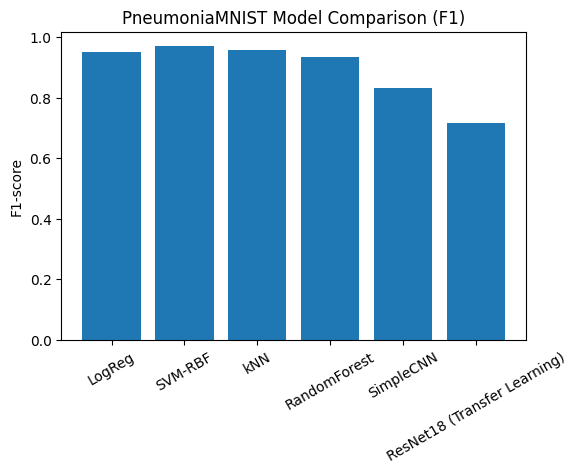

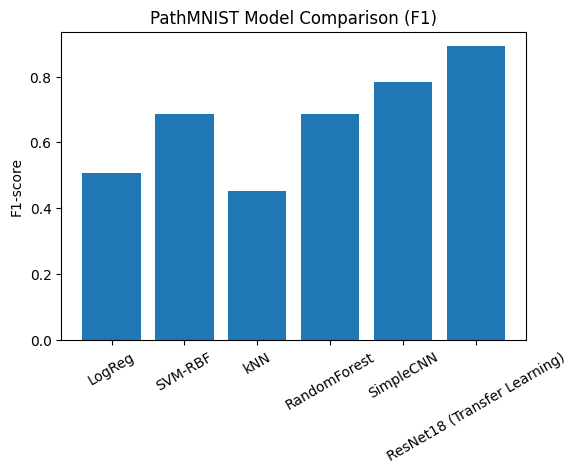

In [32]:
# Prepare data for plot_comparison from df_all

# Create separate dictionaries for each dataset
pneumonia_scores = {}
path_scores = {}

for index, row in df_all.iterrows():
    dataset = row['Dataset']
    model = row['Model']
    f1 = row['F1 Score']

    if dataset == 'pneumonia':
        pneumonia_scores[model] = {'f1': f1}
    elif dataset == 'path':
        path_scores[model] = {'f1': f1}

# Plot comparison for PneumoniaMNIST
plot_comparison(pneumonia_scores, title="PneumoniaMNIST Model Comparison (F1)")

# Plot comparison for PathMNIST
plot_comparison(path_scores, title="PathMNIST Model Comparison (F1)")

In [29]:
import pandas as pd

# Combine classical and CNN results
all_results = []

# Add classical results
for dataset, models in classical_results.items():
    for model, metrics in models.items():
        all_results.append({
            'Dataset': dataset,
            'Model': model,
            'Accuracy': metrics['accuracy'],
            'F1 Score': metrics['f1'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall']
        })

# Add CNN results
for dataset, metrics in cnn_results.items():
     all_results.append({
         'Dataset': dataset,
         'Model': 'SimpleCNN',
         'Accuracy': metrics['accuracy'],
         'F1 Score': metrics['f1'],
         'Precision': metrics['precision'],
         'Recall': metrics['recall']
     })

# Add ResNet18 results
for dataset, metrics in resnet_results.items():
    all_results.append({
        'Dataset': dataset,
        'Model': 'ResNet18 (Transfer Learning)',
        'Accuracy': metrics['accuracy'],
        'F1 Score': metrics['f1'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall']
    })


df_all = pd.DataFrame(all_results)

# Display the combined table, sorted by Dataset and then F1 Score
display(df_all.sort_values(by=['Dataset', 'F1 Score'], ascending=[True, False]))

,Dataset,Model,Accuracy,F1 Score,Precision,Recall
11,path,ResNet18 (Transfer Learning),0.899025,0.891803,0.910763,0.899025
9,path,SimpleCNN,0.788301,0.784011,0.790757,0.788301
7,path,RandomForest,0.695322,0.687533,0.700378,0.695322
5,path,SVM-RBF,0.690024,0.684994,0.692156,0.690024
4,path,LogReg,0.535286,0.507005,0.521915,0.535286
6,path,kNN,0.481307,0.451030,0.503789,0.481307
1,pneumonia,SVM-RBF,0.969466,0.969236,0.969341,0.969466
2,pneumonia,kNN,0.958015,0.957699,0.957711,0.958015
0,pneumonia,LogReg,0.952290,0.952114,0.952017,0.952290
3,pneumonia,RandomForest,0.937023,0.935948,0.936409,0.937023


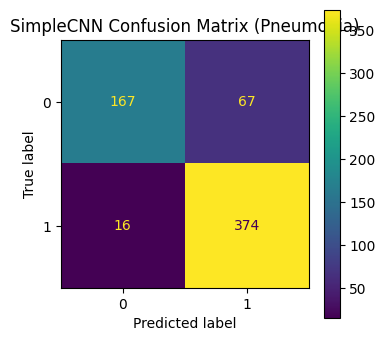

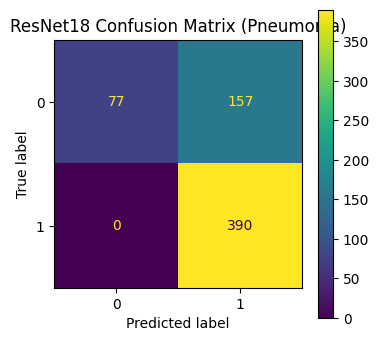

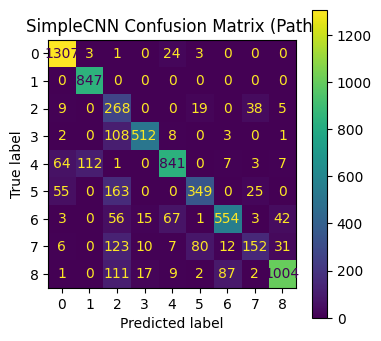

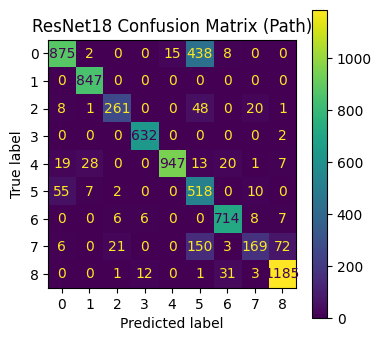

In [35]:
# Generate confusion matrices for CNN and ResNet18
for dataset_key in DATASETS.keys():
    # Plot confusion matrix for SimpleCNN
    if dataset_key in cnn_labels:
        y_true_cnn, y_pred_cnn = cnn_labels[dataset_key]
        plot_confusion(y_true_cnn, y_pred_cnn, title=f"SimpleCNN Confusion Matrix ({dataset_key.capitalize()})")

    # Plot confusion matrix for ResNet18
    if dataset_key in resnet_labels:
        y_true_resnet, y_pred_resnet = resnet_labels[dataset_key]
        plot_confusion(y_true_resnet, y_pred_resnet, title=f"ResNet18 Confusion Matrix ({dataset_key.capitalize()})")

# Modify classical evaluation to generate confusion matrices for classical models



In [36]:
def eval_classical(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    f1  = f1_score(y_val, preds, average='weighted')
    precision = precision_score(y_val, preds, average='weighted', zero_division=0)
    recall = recall_score(y_val, preds, average='weighted', zero_division=0)
    return acc, f1, precision, recall, y_val, preds

def run_classical_for_dataset(dataset_key='pneumonia'):
    train_ds = DATASETS[dataset_key]['cls'](split='train', root=data_root, download=True)
    val_ds   = DATASETS[dataset_key]['cls'](split='val', root=data_root, download=True)

    X_train, y_train = prepare_xy_for_classical(train_ds)
    X_val,   y_val   = prepare_xy_for_classical(val_ds)

    results = {}
    labels = {} # Dictionary to store true and predicted labels

    models = {
        'LogReg': LogisticRegression(max_iter=1000, n_jobs=None),
        'SVM-RBF': SVC(kernel='rbf', probability=True),
        'kNN': KNeighborsClassifier(n_neighbors=5),
        'RandomForest': RandomForestClassifier(n_estimators=200, random_state=SEED)
    }

    for name, clf in models.items():
        acc, f1, precision, recall, true_labels, predicted_labels = eval_classical(classical_pipeline(clf), X_train, y_train, X_val, y_val)
        results[name] = {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}
        labels[name] = (true_labels, predicted_labels) # Store true and predicted labels
        print(dataset_key, name, 'ACC:', round(acc,4), 'F1:', round(f1,4), 'Precision:', round(precision,4), 'Recall:', round(recall,4))

    return results, labels # Return both results and labels

classical_results = {}
classical_labels = {} # Dictionary to store labels for classical models
for key in DATASETS.keys():
    metrics, labels = run_classical_for_dataset(key)
    classical_results[key] = metrics
    classical_labels[key] = labels

print(classical_results)
# print(classical_labels) # Uncomment to see labels

pneumonia LogReg ACC: 0.9523 F1: 0.9521 Precision: 0.952 Recall: 0.9523
pneumonia SVM-RBF ACC: 0.9695 F1: 0.9692 Precision: 0.9693 Recall: 0.9695
pneumonia kNN ACC: 0.958 F1: 0.9577 Precision: 0.9577 Recall: 0.958
pneumonia RandomForest ACC: 0.937 F1: 0.9359 Precision: 0.9364 Recall: 0.937
path LogReg ACC: 0.5353 F1: 0.507 Precision: 0.5219 Recall: 0.5353
path SVM-RBF ACC: 0.69 F1: 0.685 Precision: 0.6922 Recall: 0.69
path kNN ACC: 0.4813 F1: 0.451 Precision: 0.5038 Recall: 0.4813
path RandomForest ACC: 0.6953 F1: 0.6875 Precision: 0.7004 Recall: 0.6953
{'pneumonia': {'LogReg': {'accuracy': 0.9522900763358778, 'f1': 0.9521136754326612, 'precision': 0.9520174482006544, 'recall': 0.9522900763358778}, 'SVM-RBF': {'accuracy': 0.9694656488549618, 'f1': 0.9692355082213315, 'precision': 0.9693407070001145, 'recall': 0.9694656488549618}, 'kNN': {'accuracy': 0.9580152671755725, 'f1': 0.9576988238043309, 'precision': 0.9577110022988402, 'recall': 0.9580152671755725}, 'RandomForest': {'accuracy':

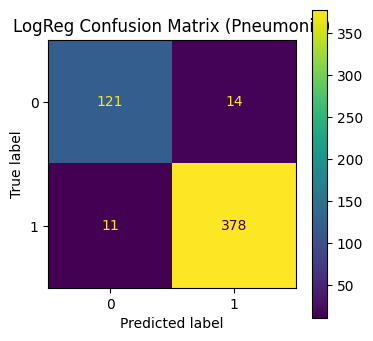

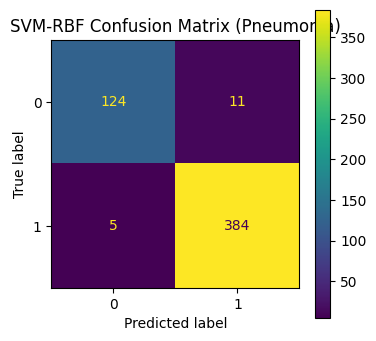

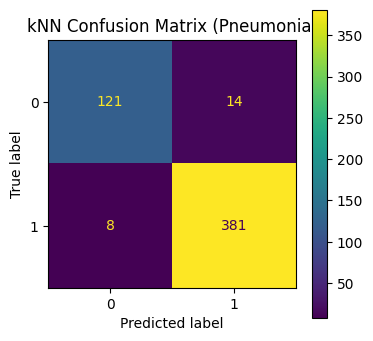

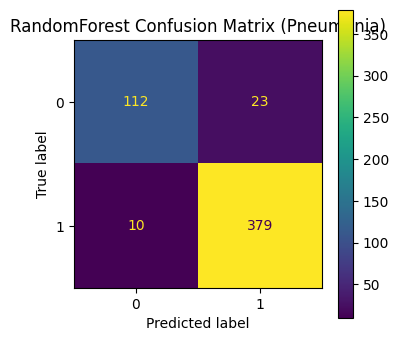

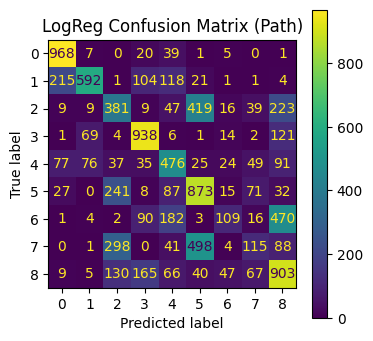

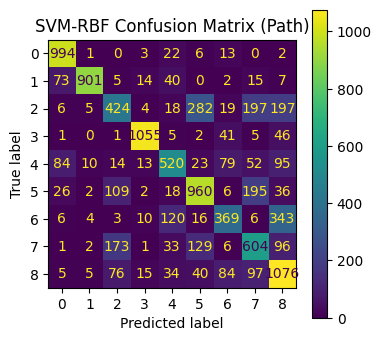

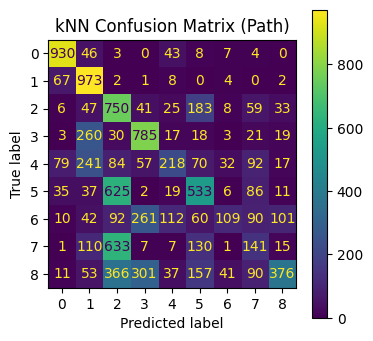

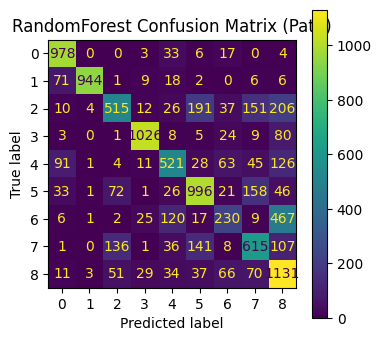

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(4,4))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax)
    ax.set_title(title)
    plt.show()

# Plot confusion matrices for classical models
for dataset_key, models_labels in classical_labels.items():
    for model_name, (y_true, y_pred) in models_labels.items():
        plot_confusion(y_true, y_pred, title=f"{model_name} Confusion Matrix ({dataset_key.capitalize()})")

# Modify cnn and resnet18 evaluation



In [38]:
def run_cnn_for(dataset_key='pneumonia', epochs=5, batch_size=128):
    train_ds, val_ds, test_ds, train_loader, val_loader, test_loader = get_dataloaders(dataset_key, batch_size=batch_size)
    n_classes = DATASETS[dataset_key]['n_classes']
    n_channels = DATASETS[dataset_key]['n_channels']
    model = SimpleCNN(in_channels=n_channels, n_classes=n_classes)
    model = train_model(model, train_loader, val_loader, epochs=epochs, lr=1e-3)
    test_acc, test_f1, test_precision, test_recall, (y_true, y_pred) = evaluate_model(model, test_loader)
    return {'accuracy': test_acc, 'f1': test_f1, 'precision': test_precision, 'recall': test_recall}, (y_true, y_pred), model # Return the trained model

def run_resnet18_for(dataset_key='pneumonia', epochs=3, lr=1e-3):
    train_loader, val_loader, test_loader = get_resnet_loaders(dataset_key)
    n_classes = DATASETS[dataset_key]['n_classes']

    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, n_classes)
    model = model.to(device)

    crit = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)

    best_val = 0.0
    for ep in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.squeeze().long().to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()

        # val
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.squeeze().long().to(device)
                preds = model(xb).argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        val_acc = correct/total
        print(f"[ResNet18 {dataset_key}] Epoch {ep+1} val_acc={val_acc:.4f}")
        best_val = max(best_val, val_acc)

    # test
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.squeeze().long().to(device)
            preds = model(xb).argmax(1)
            y_true.extend(yb.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"[ResNet18 {dataset_key}] Test ACC={acc:.4f} F1={f1:.4f} Precision={precision:.4f} Recall={recall:.4f}")
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}, (y_true, y_pred), model # Return the trained model

# Update calls to capture the returned models
cnn_results = {}
cnn_labels = {}
cnn_models = {} # Dictionary to store CNN models
for key in DATASETS.keys():
     metrics, (y_true, y_pred), model = run_cnn_for(key, epochs=5)
     cnn_results[key] = metrics
     cnn_labels[key] = (y_true, y_pred)
     cnn_models[key] = model # Store the trained model

resnet_results = {}
resnet_labels = {}
resnet_models = {} # Dictionary to store ResNet models
for key in DATASETS.keys():
    metrics, (y_true, y_pred), model = run_resnet18_for(key, epochs=3)
    resnet_results[key] = metrics
    resnet_labels[key] = (y_true, y_pred)
    resnet_models[key] = model # Store the trained model


print("CNN Results:", cnn_results)
print("ResNet18 Results:", resnet_results)

Attempting to load pneumonia dataset from: /content/drive/MyDrive/data
Epoch 1: val_acc=0.8893
Epoch 2: val_acc=0.9523
Epoch 3: val_acc=0.9542
Epoch 4: val_acc=0.9580
Epoch 5: val_acc=0.9561
Test ACC: 0.8429 F1: 0.8334 Precision: 0.8625 Recall: 0.8429
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       234
           1       0.81      0.98      0.89       390

    accuracy                           0.84       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.84      0.83       624

Attempting to load path dataset from: /content/drive/MyDrive/data
Epoch 1: val_acc=0.7149
Epoch 2: val_acc=0.7061
Epoch 3: val_acc=0.7758
Epoch 4: val_acc=0.8056
Epoch 5: val_acc=0.8107
Test ACC: 0.8288 F1: 0.8323 Precision: 0.8492 Recall: 0.8288
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1338
           1       0.83      1.00      0.91       847
           

# sample images and predictions on Pneumonia dataset


In [40]:
# Get test dataloader for pneumonia
_, _, _, _, _, test_loader_pneumonia = get_dataloaders('pneumonia', batch_size=8, download=False)

# Get a batch of images and labels
test_images, test_labels = next(iter(test_loader_pneumonia))

# Store original images and true labels
sample_images = test_images
true_sample_labels = test_labels.squeeze().numpy()

# Get predictions from classical models
classical_sample_preds = {}
# Need to flatten the images for classical models
flat_test_images = sample_images.squeeze().view(sample_images.size(0), -1).numpy()

# Use the classical_results dictionary and classical_pipeline to get predictions
for model_name, metrics in classical_results['pneumonia'].items():
    # Re-create the pipeline and fit it on the full training data necessary without saving the fitted pipelines
    # A better approach would be to save and load the fitted pipelines. Since it was taking a long time to rerun the model from the top, I decided to recreate the pipeline here.
    train_ds = DATASETS['pneumonia']['cls'](split='train', root=data_root, download=False)
    X_train, y_train = prepare_xy_for_classical(train_ds)

    # Need to get the correct classifier model instance
    if model_name == 'LogReg':
        clf = LogisticRegression(max_iter=1000, n_jobs=None)
    elif model_name == 'SVM-RBF':
        clf = SVC(kernel='rbf', probability=True)
    elif model_name == 'kNN':
        clf = KNeighborsClassifier(n_neighbors=5)
    elif model_name == 'RandomForest':
        clf = RandomForestClassifier(n_estimators=200, random_state=SEED)
    else:
        continue # Skip if model name is not recognized

    pipeline = classical_pipeline(clf)
    pipeline.fit(X_train, y_train) # Fit the pipeline
    classical_sample_preds[model_name] = pipeline.predict(flat_test_images) # Predict on the sample batch


# Get predictions from CNN model
cnn_model_pneumonia = cnn_models['pneumonia'].to(device)
cnn_model_pneumonia.eval()
with torch.no_grad():
    cnn_logits = cnn_model_pneumonia(sample_images.to(device))
    cnn_sample_preds = cnn_logits.argmax(dim=1).cpu().numpy()

# Get predictions from ResNet18 model
resnet_model_pneumonia = resnet_models['pneumonia'].to(device)
resnet_model_pneumonia.eval()
# ResNet expects 3 channels, so repeat the single channel image
resnet_images = sample_images.repeat(1, 3, 1, 1).to(device)
with torch.no_grad():
    resnet_logits = resnet_model_pneumonia(resnet_images)
    resnet_sample_preds = resnet_logits.argmax(dim=1).cpu().numpy()

# Store all predictions
sample_predictions = {
    'True Labels': true_sample_labels,
    'SimpleCNN': cnn_sample_preds,
    'ResNet18': resnet_sample_preds
}
# Add classical model predictions to the dictionary
sample_predictions.update(classical_sample_preds)

print("Sample Images shape:", sample_images.shape)
print("True Sample Labels:", true_sample_labels)
print("Sample Predictions:", sample_predictions)

Attempting to load pneumonia dataset from: /content/drive/MyDrive/data
Sample Images shape: torch.Size([8, 1, 28, 28])
True Sample Labels: [1 0 1 0 1 1 1 1]
Sample Predictions: {'True Labels': array([1, 0, 1, 0, 1, 1, 1, 1]), 'SimpleCNN': array([1, 1, 1, 0, 1, 1, 1, 1]), 'ResNet18': array([1, 1, 1, 1, 1, 1, 1, 1]), 'LogReg': array([1, 1, 1, 1, 1, 1, 1, 1]), 'SVM-RBF': array([1, 1, 1, 1, 1, 1, 1, 1]), 'kNN': array([1, 1, 1, 1, 1, 1, 1, 1]), 'RandomForest': array([1, 1, 1, 1, 1, 1, 1, 1])}


## Visualize sample predictions



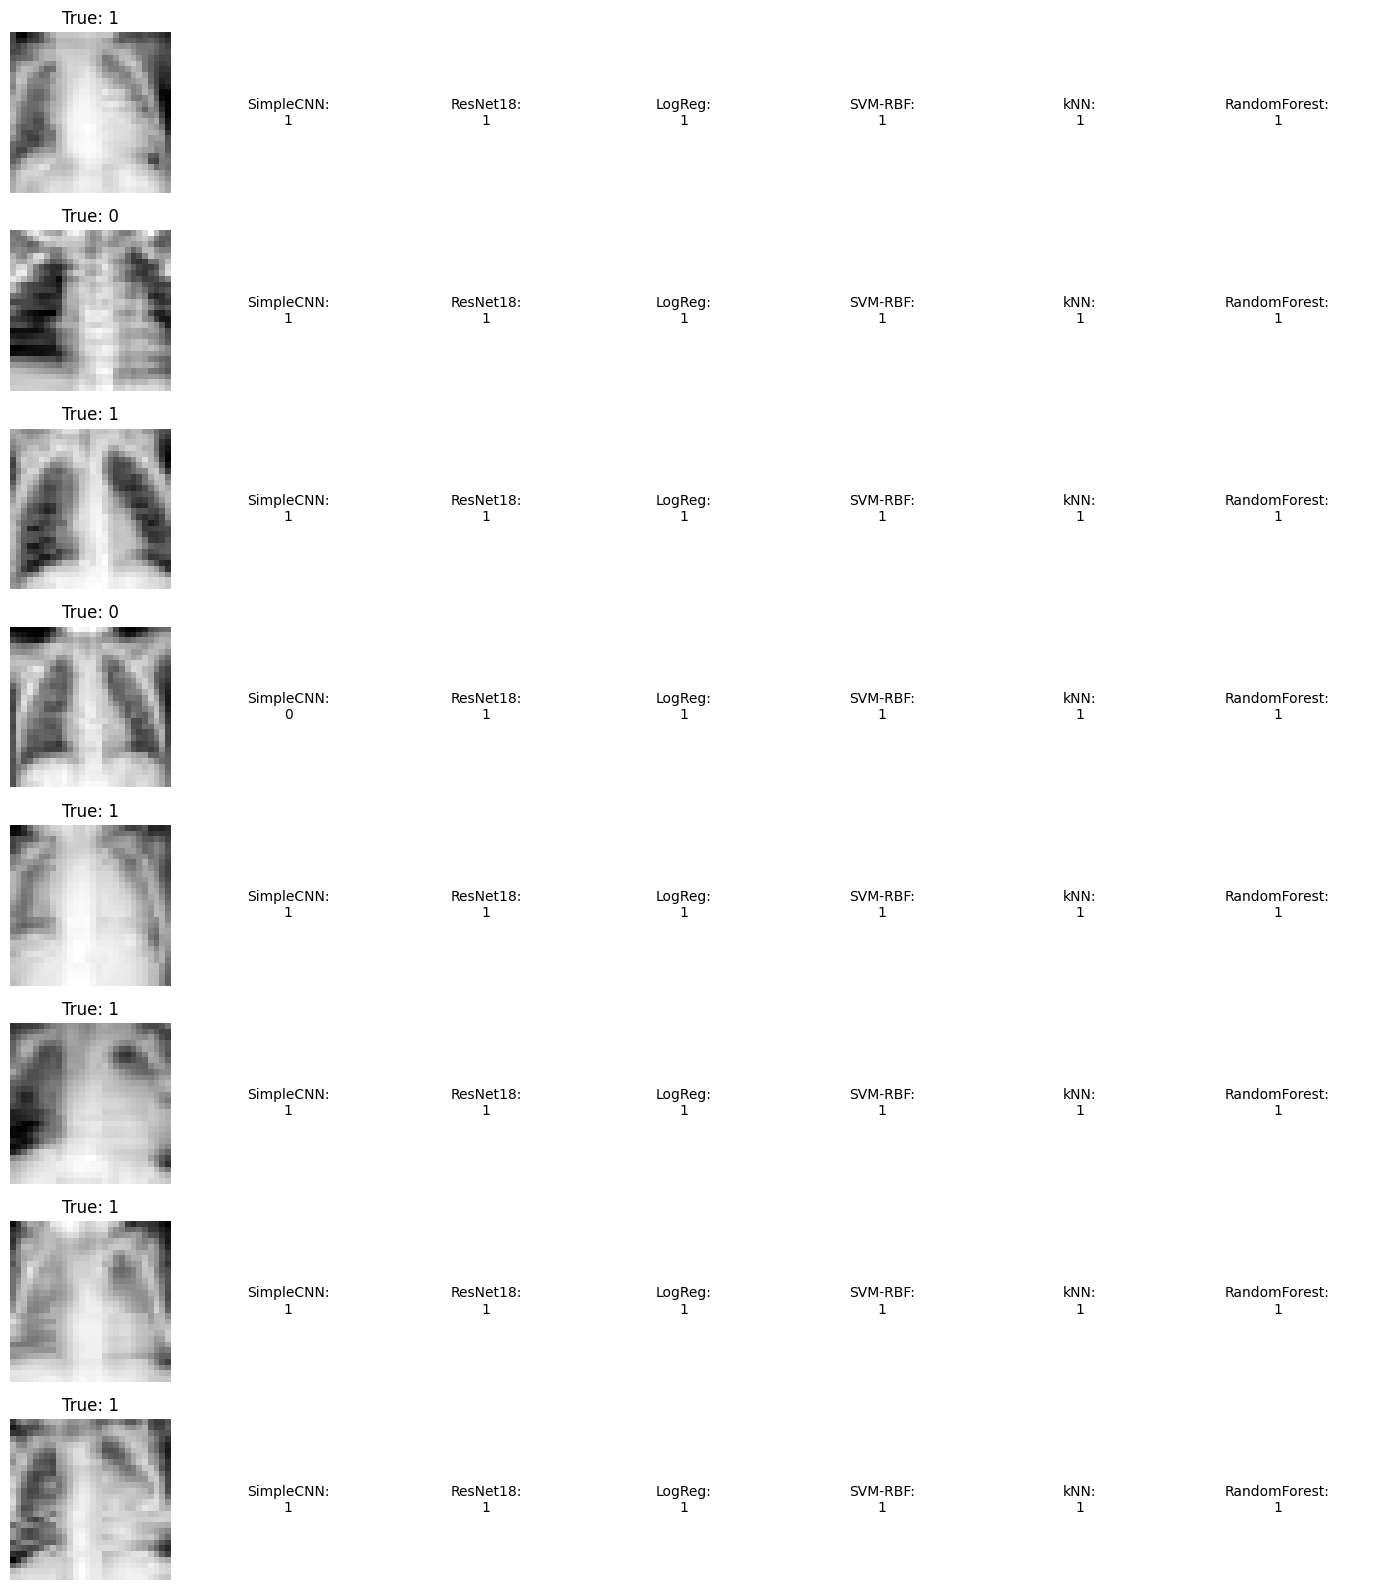

In [41]:
# Determine the number of sample images
num_samples = sample_images.size(0)

# Determine the number of models + 1 for the image itself
num_models = len(sample_predictions) - 1 # Subtract 1 for 'True Labels'
num_cols = num_models + 1

# Create a figure and a set of subplots
# Adjust figure size based on number of samples and models
fig, axes = plt.subplots(num_samples, num_cols, figsize=(num_cols * 2, num_samples * 2))

# Iterate through each sample image
for i in range(num_samples):
    # Display the image
    img_arr = sample_images[i].squeeze().numpy()
    axes[i, 0].imshow(img_arr, cmap='gray')
    axes[i, 0].set_title(f"True: {true_sample_labels[i]}")
    axes[i, 0].axis('off')

    # Iterate through each model's predictions
    col_index = 1
    for model_name, predictions in sample_predictions.items():
        if model_name == 'True Labels':
            continue # Skip the true labels entry

        predicted_label = predictions[i]
        axes[i, col_index].text(0.5, 0.5, f"{model_name}:\n{predicted_label}",
                                 horizontalalignment='center',
                                 verticalalignment='center',
                                 fontsize=10)
        axes[i, col_index].axis('off')
        col_index += 1

# Adjust layout
plt.tight_layout()
plt.show()